In [1]:
import sys,os

sys.path.append('/home/arash/ProjectVR/')

import importlib
import deepsurv
import json
import time
import numpy as np
import pandas as pd
import pickle
import theano.tensor
import lasagne
import optunity
import scipy
import scipy.stats
from scipy.stats import norm
#import logging
#from logging import handlers
#from sklearn.model_selection import train_test_split
from scipy.stats import lognorm, expon, weibull_min,gamma
importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

#from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Load trained network and data

In [2]:
#deepsurv formatted data    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'rb') as f:
    xtest=pickle.load(f)

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
    
#dataframe data with wait times and col names    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:   
    NCtest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:   
    NCtrain=pickle.load(f) 
    
network=deep_surv.load_model_from_json(model_fp = '/home/arash/ProjectVR/models/Deepwait100epochsTuned',
                     weights_fp = '/home/arash/ProjectVR/models/deepwait_weights_100_epochs.npz')

Loading json model: {"n_in": 19, "learning_rate": 0.0008208386784744157, "hidden_layers_sizes": [90, 90], "lr_decay": 0.000551240234375, "activation": "rectify", "dropout": 0.0, "batch_norm": true, "standardize": false}


### Predicting event times
To predict the time of event for instances, having an estimation of partial hazard is not sufficient. First, baseline hazard is required to estimate hazard function, which will be a function of time and covariates. The next step would be to calculate survival function. Finally, expected wait time can be calculated by:
\begin{equation}
    E(t)=\int_{t=0}^\infty S(t)dt
\end{equation}
Baseline hazard is interpreted as hazard function regardless of the values of the covariates (or when they are all 0). Different methods have been suggested in the literature for an estimation of baseline hazard. 
deepwait predicts wait time for autonmous vehicle, so the data used will be solely those ones that the car can observe, not sociodemographic etc, and the baseline hazards are calculated based on training data, as the car will not know about other pedestrians at risk etc.

In [76]:
def cumhazard (x):          #x: covariates of the instance we are looking into
    parthazard = network.hazard(x) 
    hazard = parthazard * CumBase
    return hazard[0]


### Baseline Hazard: Breslow
For CPH, the method used in python package is extracted from Breslow [1972]. In their method, "the underlying survival distribution is
parameterized as a continuous one, having constant hazards $\lambda_i$ between each
pair $t_{i-1}$ to $t_i$ of distinct relapse times. If all withdrawals, or censored observations, which
occur in the interval $(t_i, t_{i+1})$ are adjusted to have occurred at $t_i$ , the ML estimator of
$\lambda$ in terms of $\beta$ coefficients at time $t_i$ by:
\begin{equation}
\label{eq:9}
    \lambda_i=\frac{m_i}{\displaystyle \sum_{j: T_j>T_i } e^{\beta*Z_j}}
\end{equation}
in which $m_i$ is the number of events at time $t_i$, Equation above is provided for CPH. In deepwait, we replace the partial hazards part with the exp of the output of our network 

In [231]:
parthazards = network.hazard(xtrain[:,0:network.hyperparams['n_in']])               #calculate partial hazard 

NCtrain['Partial Hazards'] = parthazards

#eventtimes = NCtrain.sort_values(by=['Wait Time (s)'])['Wait Time (s)'].unique()     #sorted event times
discreteTimes = np.arange(0.0, max(NCtrain['Wait Time (s)']),0.1)   #define discrete times with 0.1 timesteps

#m_i in the baseline hazard formula, sorted by time
eventnum=[]
for t in discreteTimes:
    eventnum.append(NCtrain[(t<=NCtrain['Wait Time (s)']) &
                            (NCtrain['Wait Time (s)']<(t+0.1))].shape[0])

In [232]:
#eventnum = NCtrain['Wait Time (s)'].value_counts().sort_index() 
basehazard=[]
for i in range(len(discreteTimes)):
    basehazard.append(
        eventnum[i] / ((sum(NCtrain['Partial Hazards'][NCtrain['Wait Time (s)'] >= discreteTimes[i]])))
    )

In [233]:
# creating a df of hazards
eventsDF = pd.DataFrame({'Times': discreteTimes, 'Counts': eventnum, 'Base Hazard': basehazard })

eventsDF=eventsDF.reset_index()

eventsDF=eventsDF.drop(columns=['index'])

eventsDF.head()

,Times,Counts,Base Hazard
0,0.0,175,0.026315
1,0.1,97,0.017310
2,0.2,40,0.008040
3,0.3,47,0.009833
4,0.4,50,0.011102


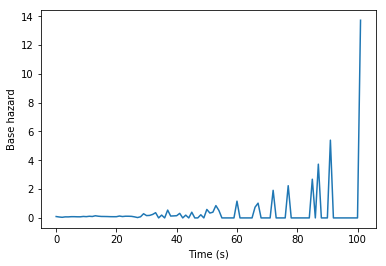

In [223]:
plt.xlabel('Time (s)')
plt.ylabel('Base hazard')
plt.plot(eventsDF['Times'],eventsDF['Base Hazard'])
plt.show()

In [234]:
#Cumulative Hazard function (integral of baseline*partial over time)
BaseoverTimes = np.array(basehazard)
CumBase = np.cumsum(BaseoverTimes)


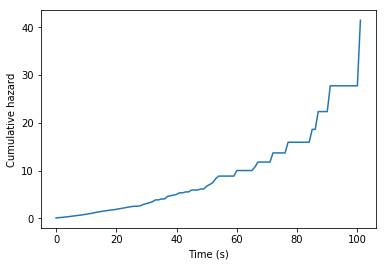

In [225]:
plt.xlabel('Time (s)')
plt.ylabel('Cumulative hazard')
plt.plot(eventsDF['Times'],CumBase)
plt.show()

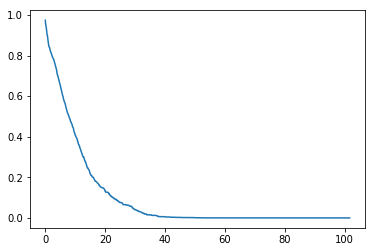

In [236]:
plt.plot(discreteTimes,np.exp(-CumBase))

In [238]:

#Train set prediction and validation
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])

for n in range(xtrain.shape[0]):
    parthazard = network.hazard(xtrain[n:n+1,0:network.hyperparams['n_in']])[0][0]
    expected = np.trapz(np.exp(-CumBase*parthazard),discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)
    



In [239]:
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index

In [240]:
AVG = pd.DataFrame(predictedwait['Wait Time (s)']).mean()
print (AVG)

Wait Time (s)    5.664353
dtype: float64


In [241]:
diff = abs(predictedwait-pd.DataFrame(NCtrain['Wait Time (s)'])).mean()
#mean difference between predicted and actual wait time 

print (diff)

Wait Time (s)    3.730516
dtype: float64


In [242]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))
#Root mean square
print (RMSE)

Wait Time (s)    6.164026
dtype: float64


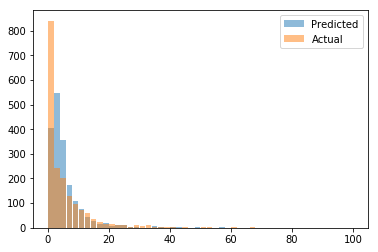

In [243]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

In [244]:
#Test set prediction and validation
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtest.shape[0]):
    hazardarray = cumhazard(xtest[n:n+1,0:network.hyperparams['n_in']])
    surv= np.exp(-hazardarray)
    expected = np.trapz(surv,discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)
    
predictedwait.index=pd.DataFrame(NCtest['Wait Time (s)']).index


RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtest['Wait Time (s)']))**2))

print (RMSE)

Wait Time (s)    7.784593
dtype: float64


### Baseline Hazard: Distributions

In [257]:
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['weibull_min']#, 'expon']#,'lognorm']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
    
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y,f0=0.61,floc=0)

            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p

        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
    
    def Plot(self,y):
        x = self.Random(n=len(y))
        size, scale = 1000, 10
        plt.hist(x, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Fitted')
        plt.hist(y, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
        plt.legend(loc='upper right')

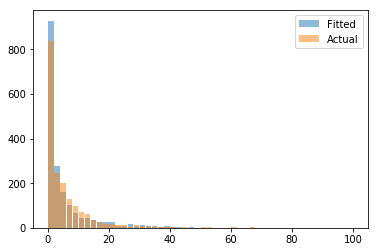

In [258]:
r = NCtrain['Wait Time (s)'].values

dst = Distribution()
dst.Fit(r)
dst.Plot(r)

In [259]:
dst.dist_results

[('weibull_min', 5.3153777664423024e-15)]

In [260]:
dst.params

{'weibull_min': (0.61, 0, 3.668768247321892)}

In [ ]:
##randgamma=gamma.rvs(0.4,0,18 ,size=len(NCtrain['Wait Time (s)'].values))

In [ ]:
#randweib=weibull_min.rvs(.61,0,3.75 ,size=len(NCtrain['Wait Time (s)'].values))

#plt.plot(gamma.pdf(discreteTimes,0.3,0,1.5),discreteTimes)
#plt.hist(r,bins=50,alpha=0.5, label='actual')
#plt.hist(randgamma,bins=50,alpha=0.5, label='random')
#plt.legend(loc='upper right')

### Weibulll

In [261]:
k = dst.params['weibull_min'][0]
lamb = dst.params['weibull_min'][2]

In [270]:
def Base(t):
    if t==0.0:
        t=0.1
    base = (k/lamb) * ((t/lamb)**(k-1))
    return base

def CumBase(t):
    CumBase=(t/lamb)**k
    return CumBase


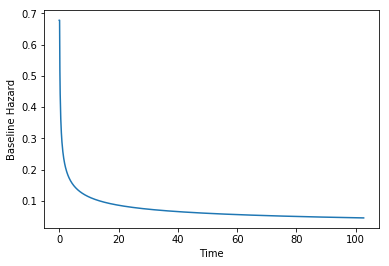

In [271]:
#Cumulative Hazard function (integral of baseline*partial over time)
discreteTimes = np.arange(0.0, max(NCtrain['Wait Time (s)'])+1,0.1)  #define discrete times with 0.1 timesteps

BaseoverTime = np.vectorize(Base)(discreteTimes)
CumBase = CumBase(discreteTimes)

plt.xlabel('Time')
plt.ylabel('Baseline Hazard')
plt.plot(discreteTimes,BaseoverTime)

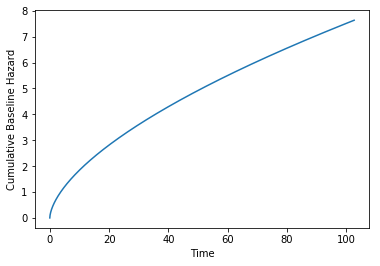

In [272]:
plt.xlabel('Time')
plt.ylabel('Cumulative Baseline Hazard')
plt.plot(discreteTimes,CumBase)

In [273]:
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtrain.shape[0]):
    hazardarray = cumhazard(xtrain[n:n+1,0:network.hyperparams['n_in']])
    surv = np.exp(-hazardarray)
    expected = np.trapz(surv,discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)

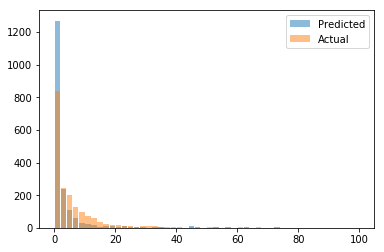

In [274]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

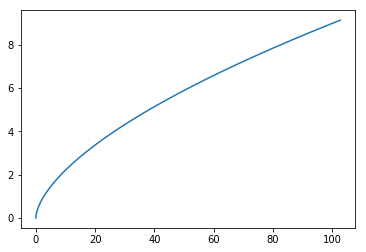

In [275]:
plt.plot(discreteTimes,(network.hazard(xtrain[0:1,0:network.hyperparams['n_in']])[0]*(CumBase)))

In [276]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE)

Wait Time (s)    10.089845
dtype: float64


### Weibull Matlab method

In [277]:
def mean_crude(t):
    step = int(t/0.1)
    p = t * BaseoverTime[step] * parthazard * np.exp(-CumBase[step] * parthazard)
    return p



#Train set prediction and validation
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])

for n in range(xtrain.shape[0]):
    parthazard = network.hazard(xtrain[n:n+1,0:network.hyperparams['n_in']])[0][0]
    expected = np.trapz(np.vectorize(mean_crude)(discreteTimes),discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)

In [278]:
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index

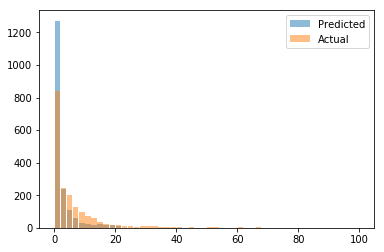

In [279]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

In [280]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE)



Wait Time (s)    7.946184
dtype: float64


In [ ]:
AVG = pd.DataFrame(predictedwait['Wait Time (s)']).mean()
print (AVG)

### Weibull Smoothe method 1.

In [73]:
def logcumbase(t):
    zed0 = k* np.log(t) - k* np.log(lamb)
    return zed0

In [ ]:
CumBase = np.exp(np.vectorize(logcumbase)(discreteTimes))

In [77]:
predictedwait = pd.DataFrame(columns=['Wait Time (s)'])
for n in range(xtrain.shape[0]):
    hazardarray = cumhazard(xtrain[n:n+1,0:network.hyperparams['n_in']])
    surv = np.exp(-hazardarray)
    expected = np.trapz(surv,discreteTimes)
    predictedwait =  predictedwait.append({'Wait Time (s)': expected}, ignore_index=True)

In [78]:
predictedwait.index=pd.DataFrame(NCtrain['Wait Time (s)']).index

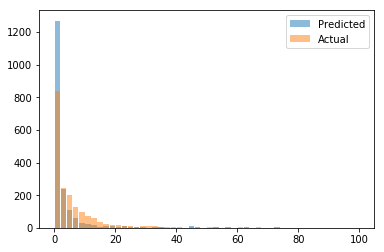

In [79]:
plt.hist(predictedwait.values, alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(NCtrain['Wait Time (s)'], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')

In [80]:
RMSE = np.sqrt(np.mean((predictedwait-pd.DataFrame(NCtrain['Wait Time (s)']))**2))

print (RMSE)


Wait Time (s)    6.817947
dtype: float64
